Assignment 4 (Due: Wed, May 12, 2021)

The devised program estimates robustly, given very noisy and very sparse data of infected and recovered of a past epidemic, the basic reproduction number of the SIR model. To keep computation in limit, we assume gamma=1. The SIR model is implemented in a minimal and optimal way, using scaled variables and a scaled time. Only the ODE part is numerically integrated that needs to be integrated. The noisy number of infected and the number of recovered are highly correlated. This relationship helps MCMC infer the parameters. 

Get familiar with the commented MCMC code below.

Task:
Change the program to the SIRD model, by including (D)eaths, with rate $\mu$. Fix not only $\gamma=1$ but also $\beta=2.5$ (or to a higher value of your choice). 
Infer the death rate $\mu$, given noisy $S(t)$, $I(t)$, $R(t)$, $D(t)$ input curves.
If you want, you can try to optimze the code (optional, very very hard). 
Also optional is: Does the inference for $\mu$ work, if $S(t)$ and/or $R(t)$ are not given ?
You may use these (initial) conditions/parameters: $$i0 = 0.01, s0 = 0.99, r0 = 0, d0 = 0, f = 3.0, timestep = 0.5.$$
You may assume values for the respective $\sigma$'s (log-normal noises) in the range of $0.2-0.4$, but not lower than $0.1$. Good luck and have fun.

In [1]:
# Assignment 4: SIR model, MCMC for R0
# Jan Nagler
# based on https://docs.pymc.io/pymc-examples/examples/ode_models/ODE_API_introduction.htm
import numpy as np
import matplotlib.pyplot as plt
%precision 4 
%matplotlib inline
import pymc3 as pm #install if necessary
from pymc3.ode import DifferentialEquation
from scipy.integrate import odeint
import warnings
warnings.filterwarnings("ignore") 
from warnings import simplefilter
# ignore all future warnings
simplefilter(action='ignore', category=FutureWarning)
np.random.seed(42)

WARNING (theano.configdefaults): g++ not available, if using conda: `conda install m2w64-toolchain`
WARNING (theano.configdefaults): g++ not detected ! Theano will be unable to execute optimized C-implementations (for both CPU and GPU) and will default to Python implementations. Performance will be severely degraded. To remove this warning, set Theano flags cxx to an empty string.
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


[2.5, 0.1]


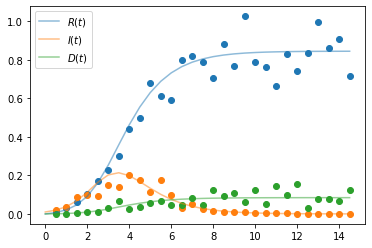

In [2]:
# Define initial conditions of SIR model
i0 = 0.01 #fractions infected at time t0=0 (1%)
r0 = 0.00 #fraction of recovered at time t0=0
d0 = 0.00
f = 3 #3.0 # time factor, defines total time window range
timestep_data = 0.5 # dt for data (e.g., weekly)
# d is mu
# ODE SIR system, only parameter p[0]=R0, for scaled time t/gamma (optimized, and 1=gamma)
def SIRD(y, t, p):
    #ds = -p[0]*y[0]*y[1] # we do not need susceptibles as S=1-I-R is determ dependent on i and r
    #dr = y[1] #component 0 = recovered, gamma=1 (will be returned directly)
    di = p[0]*(1-y[0]-y[1])*y[1] - y[1]-p[1]*y[1] #component 1 = infected, gamma=1 (SIR in one line)
    dd = p[1]*y[1]
    return [y[1],di,dd] # return r(ecov) and i(nfect)

times = np.arange(0,5*f,timestep_data)

#ground truth (fixed gamma=1, then R0=beta, time scale to t/gamma)
beta = 2.5
d = 0.1
p = [beta,d]
print(p)

# Create SIR curves
y = odeint(SIRD, t=times, y0=[r0, i0,d0], args=([p[0],p[1]],), rtol=1e-8) # r0 recovered, i0 infected  at t0
# Observational model for muliplicative noise
yobs = np.random.lognormal(mean=np.log(y[1::]), sigma=[0.2, 0.3, 0.4]) # noise is multiplicative (makes sense here)
#yobs = np.random.normal(loc=(y[1::]), scale=[0.030, 0.060]) # noise is additive (wrong here)

# Plot the deterministic curves, and those with multiplicative noise
plt.plot(times[1::],yobs, marker='o', linestyle='none')
plt.plot(times, y[:,0], color='C0', alpha=0.5, label=f'$R(t)$')
plt.plot(times, y[:,1], color ='C1', alpha=0.5, label=f'$I(t)$')
plt.plot(times, y[:,2], color ='C2', alpha=0.5, label=f'$D(t)$')
plt.legend()
plt.show()

Only 10 samples in chain.
Sequential sampling (2 chains in 1 job)
NUTS: [d, beta, sigma]


Sampling 2 chains for 1_000 tune and 10 draw iterations (2_000 + 20 draws total) took 18443 seconds.


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
sigma[0],0.34,0.06,0.25,0.44,0.01,0.01,19.0,14.0,1.09
sigma[1],0.40,0.09,0.27,0.54,0.02,0.02,19.0,10.0,1.05
sigma[2],2.03,0.31,1.62,2.32,0.06,0.04,26.0,22.0,0.94
beta,3.29,0.04,3.23,3.37,0.01,0.01,20.0,22.0,1.01
d,1.02,0.02,1.00,1.04,0.00,0.00,15.0,14.0,1.15


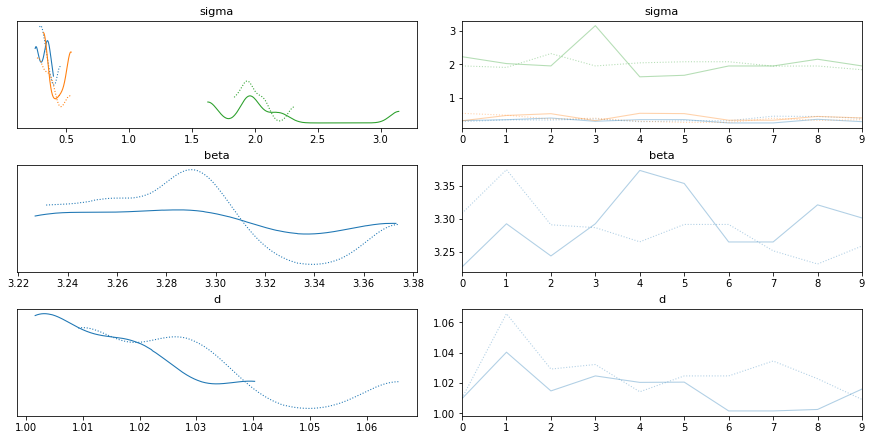

In [3]:
# ODE system container
sir_model = DifferentialEquation(
    func = SIRD,
    times = np.arange(timestep_data,5*f,timestep_data), #start at t=t_1 (and not t0=0, where log(R=0)=undef)
    n_states = 3, #r(ecovered) and i(nfected) are states
    n_theta = 2, # beta=R0 only parameter
    t0 = 0 # start from zero
)

# Define and perform MCMC
with pm.Model() as basic_model:

    # Distribution of variances, sigma[0] and sigma[1], some good choice, pos. chauchy  
    sigma = pm.HalfCauchy( 'sigma', 1, shape=3 )

    # Prior: R0 is bounded from below (lower=1), (R0, mu=2, sigma=3)
    #R0 = pm.Bound(pm.Normal, lower=1)( 'R0', 2, 3 ) # guess of how R0 distribution looks like = Guassian, mean>1
    beta_prior = pm.Bound(pm.Normal, lower=1)( 'beta', 2, 3 ) # guess of how R0 distribution looks like = Guassian, mean>1
    d_prior = pm.Bound(pm.Normal, lower=1)( 'd', 2, 3 ) # ??? no idea
    
    # Our deterministic curves
    sir_curves = sir_model( y0=[r0, i0,d0], theta=[beta_prior,d_prior] ) # assume gamma = 1, then beta=R0

    # Likelihood function choice: our sampling distribution for multiplicative noise around the I and R curves
    Y = pm.Lognormal('Y', mu=pm.math.log(sir_curves), sd=sigma, observed=yobs) # variances via sigmas, data=yobs
    
    start = pm.find_MAP()
    
    step = pm.NUTS()
    
    trace = pm.sample(10, step=step, cores=1, random_seed=44) #set here number of cores, to adapt for hardware

# Plot results (takes a while, be patient)
pm.traceplot(trace)
pm.summary(trace).round(2)

array([[<AxesSubplot:ylabel='sigma\n1'>, <AxesSubplot:>, <AxesSubplot:>,
        <AxesSubplot:>],
       [<AxesSubplot:ylabel='sigma\n2'>, <AxesSubplot:>, <AxesSubplot:>,
        <AxesSubplot:>],
       [<AxesSubplot:ylabel='beta'>, <AxesSubplot:>, <AxesSubplot:>,
        <AxesSubplot:>],
       [<AxesSubplot:xlabel='sigma\n0', ylabel='d'>,
        <AxesSubplot:xlabel='sigma\n1'>, <AxesSubplot:xlabel='sigma\n2'>,
        <AxesSubplot:xlabel='beta'>]], dtype=object)

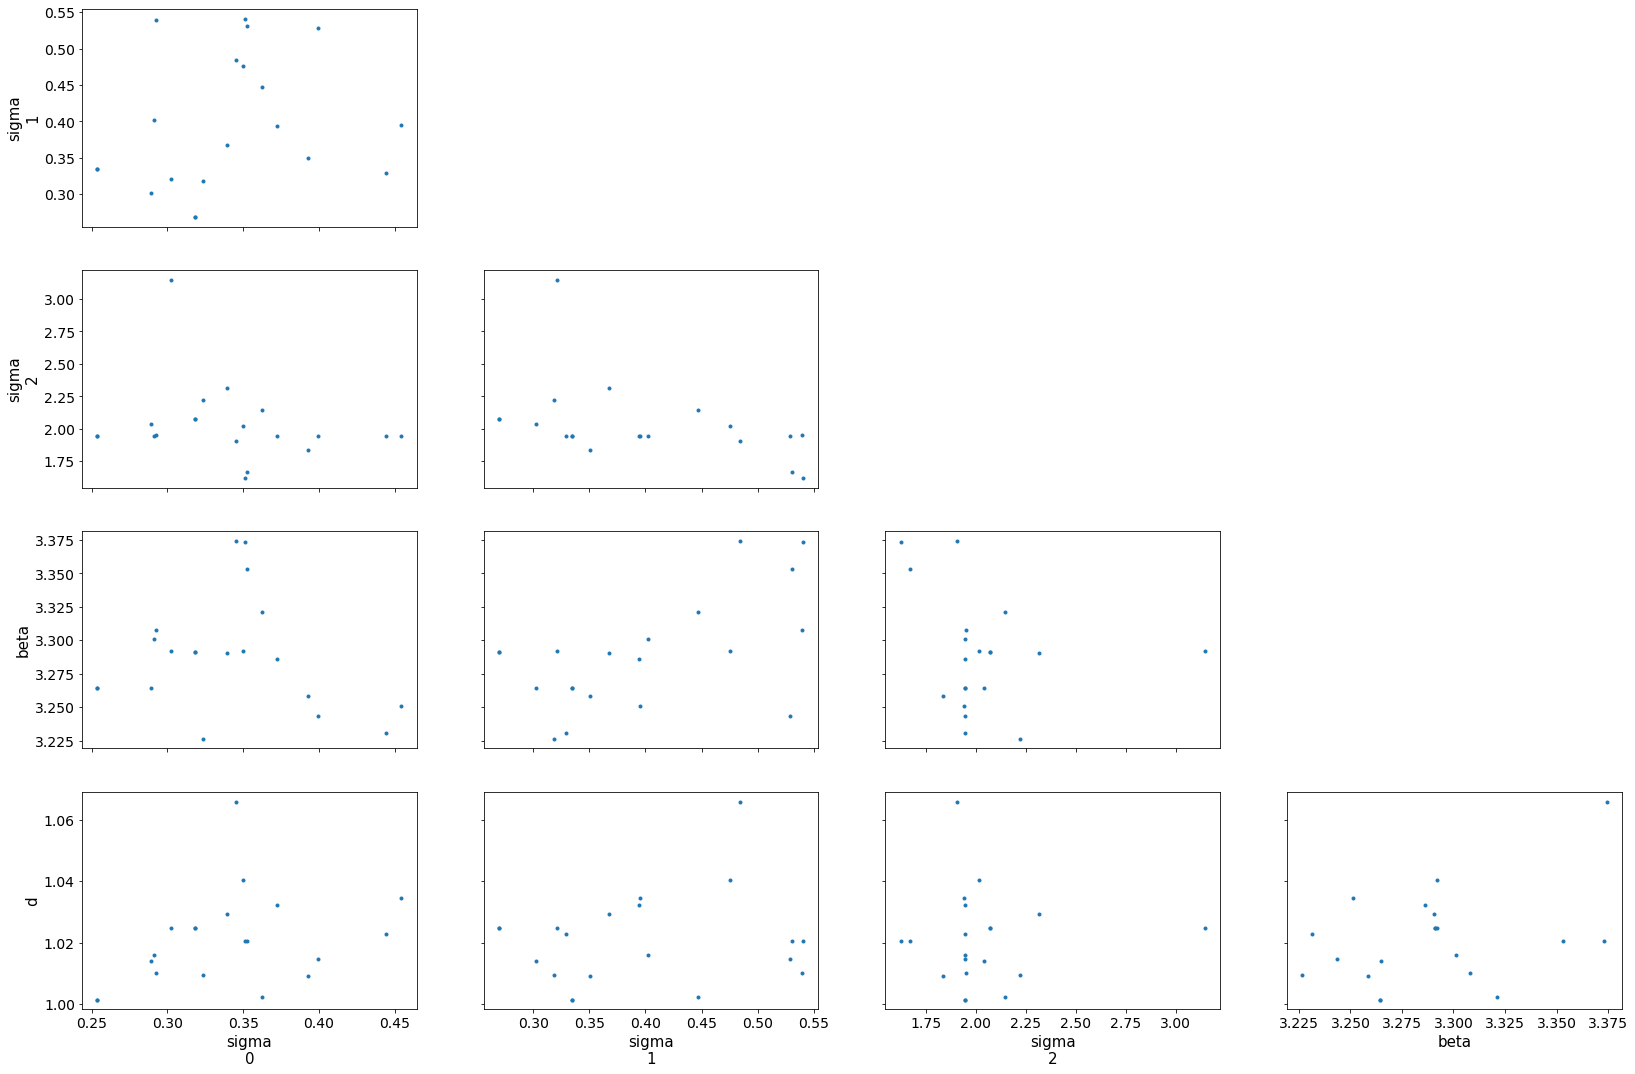

In [4]:
pm.pairplot(trace)

In [6]:
print(start)

{'sigma_log__': array([-1.088 , -1.0237,  0.7139]), 'beta_lowerbound__': array(0.8111), 'd_lowerbound__': array(-16.4464), 'sigma': array([0.3369, 0.3593, 2.042 ]), 'beta': array(3.2504), 'd': array(1.)}


In [11]:
print(trace['beta'][-10:])
print(trace['d'][-10:])
print(trace['sigma'][-10:])

[3.3081 3.3743 3.2907 3.2863 3.2648 3.2912 3.2912 3.2512 3.2311 3.2584]
[1.0101 1.0657 1.0292 1.0322 1.0142 1.0247 1.0247 1.0345 1.0228 1.0091]
[[0.2927 0.5391 1.9499]
 [0.3452 0.4839 1.9047]
 [0.3392 0.3673 2.3158]
 [0.3722 0.3941 1.9489]
 [0.2891 0.3021 2.0406]
 [0.3183 0.2693 2.0731]
 [0.3183 0.2693 2.0731]
 [0.4545 0.3951 1.9435]
 [0.4442 0.3289 1.9466]
 [0.3928 0.3505 1.8356]]
